In [1]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.compose import ColumnTransformer

import joblib

import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
cwd = os.getcwd()

In [3]:
parent_dir = os.path.dirname(cwd)

In [4]:
train_files = joblib.load(f'{parent_dir}/FEMH_train_files.pkl')
test_files = joblib.load(f'{parent_dir}/FEMH_test_files.pkl')

In [5]:
femh_df = pd.read_csv(f"{parent_dir}/Raw Features/FeatureStates_FEMH.csv", index_col=0)
femh_df['filename'] = femh_df['file'].str.split('.', expand=True)[0]
femh_df = femh_df.drop(['file'], axis=1)
femh_df.head()

,0,1,2,3,4,5,6,7,8,9,...,504,505,506,507,508,509,510,511,pathology,filename
0,0.198858,-0.671097,-0.553800,0.430371,0.689427,0.451664,0.513923,-0.669326,3.029441,-0.140924,...,-0.467423,0.029338,0.752360,-0.578080,1.039529,0.202895,1.363360,0.883992,Atrophy,Atrophy-00002mg
1,0.545076,-0.047681,-1.163096,0.268823,0.509433,-0.136339,0.201685,-0.742708,-0.094480,0.041155,...,1.091321,-0.360934,0.273519,-0.935269,-0.079642,-0.262875,-0.492177,0.851083,Atrophy,Atrophy-0001297
2,0.298088,-0.969536,-1.342669,0.438397,-0.010687,0.756730,0.694832,2.412334,0.193469,2.678018,...,-1.588670,-1.013131,0.818641,4.835070,-0.309830,0.503137,1.045041,0.546520,Atrophy,Atrophy-0001apo
3,0.297540,-0.991699,2.728217,-0.110462,0.275403,0.368062,-0.597715,-0.435604,6.930976,-0.512924,...,-1.465304,-1.550032,0.370240,0.287871,1.318349,0.779946,2.578023,0.359360,Atrophy,Atrophy-0001qd3
4,0.569070,-0.708248,-0.532420,0.829588,0.291864,-0.042466,-0.483135,-1.057416,2.885130,0.608033,...,1.912285,1.891305,0.523399,-0.637222,0.400236,0.318714,-0.948448,0.026111,Atrophy,Atrophy-0002ipt


In [6]:
demographics = pd.read_pickle(f'{parent_dir}/Audio/medicalhistory.pkl')
demographics = demographics.drop(['ID', 'Disease category', 'pathology'], axis=1)
# demographics = demographics[['Sex', 'Age', 'filename']]
demographics = demographics.drop(['Sex', 'Age'], axis=1)
demographics.head()

,Narrow pitch range,Decreased volume,Fatigue,Dryness,Lumping,Heartburn,Choking,Eye dryness,PND,Smoking,...,Noise at work,Occupational vocal demand,Diabetes,Hypertension,CAD,Head and Neck Cancer,Head injury,CVA,Voice handicap index - 10,filename
0,0,0,0,0,0,0,1,0,0,0,...,1,2,0,0,0,0,0,0,12,Atrophy-00002mg
1,0,0,0,0,0,0,1,0,0,0,...,1,4,0,1,0,0,0,1,36,Atrophy-0001297
2,0,0,0,1,0,0,0,0,1,0,...,1,3,0,0,0,0,0,0,16,Atrophy-0001apo
3,1,1,0,0,1,0,0,0,1,0,...,1,3,0,0,1,0,0,0,19,Atrophy-0001qd3
4,0,0,0,1,0,0,0,0,0,0,...,1,2,0,0,1,0,0,0,34,Atrophy-0002ipt


In [7]:
df = pd.merge(femh_df, demographics, on='filename', how='inner')
df = femh_df.copy()
df.head()

,0,1,2,3,4,5,6,7,8,9,...,504,505,506,507,508,509,510,511,pathology,filename
0,0.198858,-0.671097,-0.553800,0.430371,0.689427,0.451664,0.513923,-0.669326,3.029441,-0.140924,...,-0.467423,0.029338,0.752360,-0.578080,1.039529,0.202895,1.363360,0.883992,Atrophy,Atrophy-00002mg
1,0.545076,-0.047681,-1.163096,0.268823,0.509433,-0.136339,0.201685,-0.742708,-0.094480,0.041155,...,1.091321,-0.360934,0.273519,-0.935269,-0.079642,-0.262875,-0.492177,0.851083,Atrophy,Atrophy-0001297
2,0.298088,-0.969536,-1.342669,0.438397,-0.010687,0.756730,0.694832,2.412334,0.193469,2.678018,...,-1.588670,-1.013131,0.818641,4.835070,-0.309830,0.503137,1.045041,0.546520,Atrophy,Atrophy-0001apo
3,0.297540,-0.991699,2.728217,-0.110462,0.275403,0.368062,-0.597715,-0.435604,6.930976,-0.512924,...,-1.465304,-1.550032,0.370240,0.287871,1.318349,0.779946,2.578023,0.359360,Atrophy,Atrophy-0001qd3
4,0.569070,-0.708248,-0.532420,0.829588,0.291864,-0.042466,-0.483135,-1.057416,2.885130,0.608033,...,1.912285,1.891305,0.523399,-0.637222,0.400236,0.318714,-0.948448,0.026111,Atrophy,Atrophy-0002ipt


In [8]:
df['pathology'].value_counts()

pathology
Polyp                       202
Nodules                     200
Atrophy                     189
Cyst                        175
Vocal paresis               164
Vocal palsy                 164
Reinke’s edema              144
Sulcus                      127
Muscle tension dysphonia    117
Presbyphonia                115
Vocal process granuloma      86
Fibrous mass                 84
Ulcer                        64
Spasmodic dysphonia          34
Laryngeal cancer             31
Dysplasia                    29
Papilloma                    28
Tremor                       18
Scar                         15
Varix                        14
Name: count, dtype: int64

In [9]:
# Pathologies to be replaced with "Malignant"
malignant_pathologies = ['Laryngeal cancer', 'Dysplasia']

# Replace specified pathologies with "Malignant"
df['pathology'] = df['pathology'].apply(lambda x: 'Malignant' if x in malignant_pathologies else 'Benign')

In [10]:
df['pathology'].value_counts()

pathology
Benign       1940
Malignant      60
Name: count, dtype: int64

In [11]:
train_df = df[df['filename'].isin(train_files)]
train_df = train_df.reset_index(drop=True)

In [12]:
X_train = train_df.drop(['pathology', 'filename'], axis=1)
y_train = train_df['pathology']

In [13]:
X_train.shape

(1340, 512)

In [14]:
audio_features = femh_df.columns.drop(['pathology', 'filename'])
audio_features

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '502', '503', '504', '505', '506', '507', '508', '509', '510', '511'],
      dtype='object', length=512)

In [15]:
symptom_features = X_train.columns.drop(audio_features)
symptom_features

Index([], dtype='object')

In [16]:
# Define the preprocessing and feature selection for audio features
audio_preprocessing = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Imputer step
    ('scaler', StandardScaler()),  # Scaling step
    ('feature_selection', SelectFromModel(DecisionTreeClassifier(random_state=42)))  # Feature Selection
])

In [17]:
# Define the preprocessing for symptoms (imputation and scaling only)
symptom_preprocessing = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),  # Imputer step
    ('scaler', StandardScaler())  # Scaling step
])

In [18]:
# Combine the preprocessing and feature selection for audio features with symptom preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('audio', audio_preprocessing, audio_features),
        ('symptoms', symptom_preprocessing, symptom_features)
    ]
)

In [19]:
pipeline = ImPipeline(steps=[
('preprocessor', preprocessor),
('smote', SMOTE(random_state=42)),  # SMOTE for handling class imbalance
('classifier', MLPClassifier(random_state=42, early_stopping=True)) # MLP Classifier step
])

In [20]:
param_grid = {
    'classifier__hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 100), (50, 50, 50)],
    'classifier__activation': ['relu', 'tanh'],
    'classifier__solver': ['adam', 'sgd', 'lbfgs'],
    'classifier__learning_rate': ['constant', 'invscaling', 'adaptive'],
}

In [21]:
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='balanced_accuracy', verbose=3, return_train_score=True)

In [22]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
[CV 1/5] END classifier__activation=relu, classifier__hidden_layer_sizes=(50,), classifier__learning_rate=constant, classifier__solver=adam;, score=(train=0.945, test=0.817) total time=   1.3s
[CV 2/5] END classifier__activation=relu, classifier__hidden_layer_sizes=(50,), classifier__learning_rate=constant, classifier__solver=adam;, score=(train=0.975, test=0.552) total time=   1.2s
[CV 3/5] END classifier__activation=relu, classifier__hidden_layer_sizes=(50,), classifier__learning_rate=constant, classifier__solver=adam;, score=(train=0.979, test=0.601) total time=   1.4s
[CV 4/5] END classifier__activation=relu, classifier__hidden_layer_sizes=(50,), classifier__learning_rate=constant, classifier__solver=adam;, score=(train=0.977, test=0.687) total time=   1.5s
[CV 5/5] END classifier__activation=relu, classifier__hidden_layer_sizes=(50,), classifier__learning_rate=constant, classifier__solver=adam;, score=(train=0.983, test

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('audio',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler()),
                                                                                         ('feature_selection',
                                                                                          SelectFromModel(estimator=DecisionTreeClassifier(random_state=42)))]),
                                                                         Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '502', '503', '504', '505', '506', '507',...
                                        MLPClassifier(early_stopping=True,
                                                      random_state=42))]),
             param_grid={'classifier__activation': ['relu', 'tanh'],
                         'classifier__hidden_layer_sizes': [(50,), (100,),
                                                            (100, 50),
                                                            (100, 100),
                                                            (50, 50, 50)],
                         'classifier__learning_rate': ['constant', 'invscaling',
                                                       'adaptive'],
                         'classifier__solver': ['adam', 'sgd', 'lbfgs']},
             return_train_score=True, scoring='balanced_accuracy', verbose=3)

In [23]:
# Best parameters from GridSearchCV
print(f'Best parameters: {grid_search.best_params_}')

# Best estimator from GridSearchCV
best_pipeline = grid_search.best_estimator_

Best parameters: {'classifier__activation': 'tanh', 'classifier__hidden_layer_sizes': (100, 50), 'classifier__learning_rate': 'adaptive', 'classifier__solver': 'sgd'}


In [24]:
cv_results = grid_search.cv_results_

best_index = grid_search.best_index_
print("Cross-validation results for the best parameters:")

print(f"Mean test score: {cv_results['mean_test_score'][best_index]}")
print(f"Mean train score: {cv_results['mean_train_score'][best_index]}")

Cross-validation results for the best parameters:
Mean test score: 0.7625068418171868
Mean train score: 0.8468253968253968


In [25]:
joblib.dump(grid_search, 'NN_FeatureStates_Rec_Only.pkl', compress=True)

['NN_FeatureStates_Rec_Only.pkl']

# Test - holdout

In [26]:
test_df = df[df['filename'].isin(test_files)]
test_df = test_df.reset_index(drop=True)

In [27]:
X_test = test_df.drop(['pathology', 'filename'], axis=1)
y_test = test_df['pathology']

In [28]:
# Predict on the test set
y_pred = best_pipeline.predict(X_test)

# Evaluate the classifier
accuracy = balanced_accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.3f}')

Accuracy: 0.683


In [29]:
pathologies = df['pathology'].unique()
pathologies

array(['Benign', 'Malignant'], dtype=object)

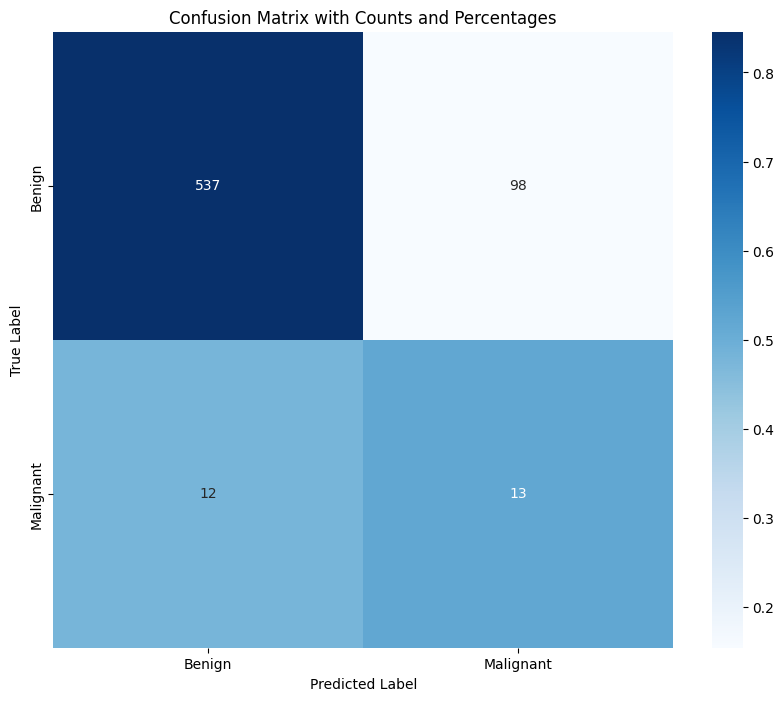

In [30]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=pathologies)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=cm, fmt='d', cmap='Blues', xticklabels=pathologies, yticklabels=pathologies)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix with Counts and Percentages')
plt.show()